# Leaky integrate and fire model

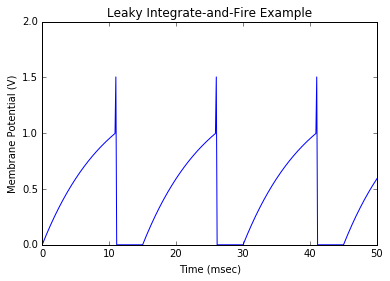

In [2]:
# -*-coding:utf-8 -*

""" On rajoute une période réfractaire par rapport au modele classique et on utilise la méthode d'Euler"""

from numpy import *
from pylab import *
import csv
%matplotlib inline

## setup parameters and state variables
T       = 50                  # total time to simulate (msec)
dt      = 0.125               # simulation time step (msec)
time    = arange(0, T+dt, dt) # time array
t_rest  = 0                   # initial refractory time

## LIF properties
Vm      = zeros(len(time))    # potential (V) trace over time 
Rm      = 1                   # resistance (kOhm)
Cm      = 10                  # capacitance (uF)
tau_m   = Rm*Cm               # time constant (msec)
tau_ref = 4                   # refractory period (msec)
Vth     = 1                   # spike threshold (V)
V_spike = 0.5                 # spike delta (V)

## Input stimulus
I       = 1.5                 # input current (A)

## iterate over each time step
for i, t in enumerate(time): 
  if t > t_rest:
    Vm[i] = Vm[i-1] + (-Vm[i-1] + I*Rm) / tau_m * dt
    if Vm[i] >= Vth:
      Vm[i] += V_spike
      t_rest = t + tau_ref

## plot membrane potential trace  
plot(time, Vm)
title('Leaky Integrate-and-Fire Example')
ylabel('Membrane Potential (V)')
xlabel('Time (msec)')
ylim([0,2])
show()


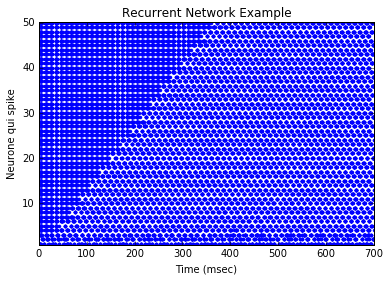

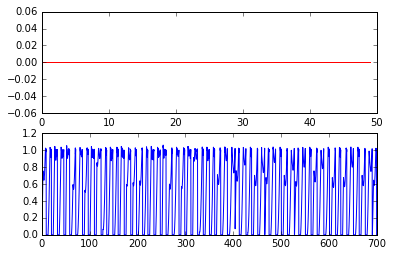

In [5]:
""" Le but est d'essayer de modeliser les synapses a l'aide de matrices, avec le modèle LIF """


## setup parameters and state variables
N    = 50                      # number of neurons
T    = 700                     # total time to simulate (msec)
dt   = 0.125                   # simulation time step (msec)
time = np.arange(0, T+dt, dt)  # time array


## LIF properties
Vm      = np.zeros([N,len(time)])  # potential (V) trace over time
tau_m   = 10                       # time constant (ms)
tau_ref = 4                        # refractory period (ms)
tau_psc = 5                        # post synaptic current filter time constant(ms)
Vth     = 1                        # spike threshold (V)
#for i in range(N):                 # random initialization (V)
#    Vm[i,0] = Vm[i,0] + random.random() 
#    


## Currents
I    = np.zeros((N,len(time)))
Iext = np.zeros(N) # externally applied stimulus
Iext[0] = 1.5 # Only on the first neuron

phase=[]
tau=[]


## Synapse weight matrix
# equally weighted ring connectivity
synapses = np.eye(N)
synapses = (np.roll(synapses, -1, 1)) # need connectivity by pairs

# randomly weighted full connectivity
#synapses = np.random.rand(N,N)*0.3


## Synapse current model, see p200 in the first book
def Isyn(t):
    '''t is an array of times since each neuron's last spike event'''
    t[np.nonzero(t < 0)] = 0
    return t*np.exp(-t/tau_psc)
last_spike = np.zeros(N) - tau_ref

## Simulate network
raster = np.zeros([N,len(time)])*np.nan #Une histoire de tracé de fonctions recup sur internet
for k in range(20):
 tau_psc=tau_psc+1
 last_spike = np.zeros(N) - tau_ref
 I    = np.zeros((N,len(time)))
 Iext = np.zeros(N) # externally applied stimulus
 Iext[0] = 1.5 # Only on the first neuron
 for i, t in enumerate(time[1:],1): # 1 initialement
    active = np.nonzero(t > last_spike + tau_ref)
    Vm[active,i] = Vm[active,i-1] + (-Vm[active,i-1] + I[active,i-1]) / tau_m * dt # Eulers method

    spiked = np.nonzero(Vm[:,i] > Vth)
    last_spike[spiked] = t
    raster[spiked,i] = spiked[0]+ 1
    I[:,i] = Iext + synapses.dot(Isyn(t - last_spike))


## plot membrane potential trace
plot(time, np.transpose(raster), 'b.')
title('Recurrent Network Example')
ylabel('Neurone qui spike')
xlabel('Time (msec)')
ylim([0.75,N+0.25])

figure(2)
subplot(211)
plot((Vm[:,0]),'r')
subplot(212)
plot(time,Vm[1,:],'b')



show()

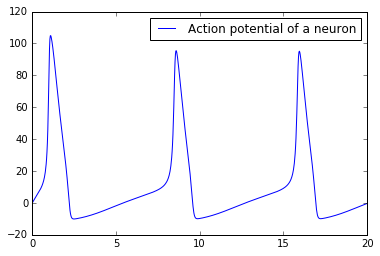

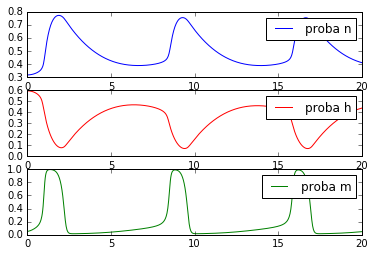

In [4]:
#Il s'agit de la simulation du modèle de Hodgkin_Huxley 
# On représente les canaux par des probabilités d'ouvertures données par la théorie(page 190)
#Resolution par une méthode rk4

import matplotlib.pyplot as plt
import numpy as np
from math import *
%matplotlib inline

# Tous les alphas avec mise du potentiel au repos a 0mV a l'aide de fits experimentaux

def alh(U):
    return 0.07 * np.exp(-U/20.)

def alm(U):
    return 0.1*(25.-U)/((np.exp((25.-U)/10.)) -1.)

def aln(U) :
    return 0.01*(10.-U) / ((np.exp((10.-U)/10.))-1.)

# Tous les betas avec le meme decalage de potentiel a l'aide des memes fits

def beh(U):
    return 1./(np.exp((30.-U)/10.)+1.)

def bem(U):
    return 4.* np.exp(-U/18.)

def ben(U) :
    return 0.125 * np.exp(-U/80.)


# FONCTION PROBA OUVERTURE des canaux avec pp: proba de passer

def ouverture(al, pp, be):
    return (al * ( 1 - pp )) - (be * pp)
 



# Définition des parametres
V_reset=0
V_stop=15
m_inf= lambda v: alm(v)/(alm(v)+bem(v))
n_inf= lambda v: aln(v)/(aln(v)+ben(v))
h_inf= lambda v: alh(v)/(alh(v)+beh(v))

   # constantes du courant de fuite en mV
EL = 10.6
gL = 0.3
    
    # constantes du courant K en mV
gK = 36.
EK = -12.
    
    # constantes du courant NA en mV
gNa = 120.
ENa = 115.

  # vecteurs de stockage et conditions initiales
tps = [0.]
V=[V_reset]
m=[m_inf(V_reset)]
n = [n_inf(V_reset)]
h = [h_inf(V_reset)]
K = [0.] #courant correspo0ndant a K
Na = [0.] #courant correspondant a Na

## variables temporelles
T     = 20    # ms
dt    = 0.025 # ms
time  = np.arange(0,T+dt,dt)

    #definition du courant imposé (stimulus)
I = np.zeros(len(time))

for i, t in enumerate(time):
    I[i] = 10 # uA/cm2

    


#Fonction de courant de fuite 
def im(V,i,n,m,h):

    return gl*(V-El) + gk*(n[i]**4)*(V-Ek)+ gna*(m[i]**3)*h[i]*(V-Ena) 



#Equation differentielle de V

def eqV(V,t):  #I=Rm*Ie(t)/taum

    return I[t] - (gL*(V-EL) + gK*(n[t]**4)*(V-EK)+ gNa*(m[t]**3)*h[t]*(V-ENa))





# Fonction resolvant le probleme a l'aide de rk4

def rk4HH(C=1.):   # C=cm pris egal a 1 dans les simulations, Tmax en ms
 
 
    # boucle sur le temps 
    
    for t in range(1,len(time)):
        pas=dt

#Resolution de n
        k1 = ouverture ( aln(V[ t-1 ]) ,n[t-1],ben(V[ t-1 ])) # k1 = f(y , t)
        k2 = ouverture (aln(V[ t-1 ]), n[ t-1 ]+ pas * k1 , ben(V[ t-1 ]))
        k3 = ouverture (aln(V[ t-1 ]), n[ t-1 ]+ pas * k2 , ben(V[ t-1 ]))
        k4 = ouverture (aln(V[ t-1 ]), n[ t-1 ]+2* pas* k3 , ben(V[ t-1 ]) )
        n.append( n[t-1 ]+ pas /3*( k1 +2* k2 +2* k3 + k4 ))

#Resolution de m
        k1 = ouverture ( alm(V[ t-1 ]) ,m[t-1],bem(V[ t-1 ])) # k1 = f(y , t)
        k2 = ouverture (alm(V[ t-1 ]), m[ t-1 ]+ pas * k1 , bem(V[ t-1 ]))
        k3 = ouverture (alm(V[ t-1 ]), m[ t-1 ]+ pas * k2 , bem(V[ t-1 ]))
        k4 = ouverture (alm(V[ t-1 ]), m[ t-1 ]+2* pas* k3 , bem(V[ t-1 ]) )
        m.append( m[t-1 ]+ pas /3*( k1 +2* k2 +2* k3 + k4 ))

#Resolution de h
        k1 = ouverture ( alh(V[ t-1 ]) ,h[t-1],beh(V[ t-1 ])) # k1 = f(y , t)
        k2 = ouverture (alh(V[ t-1 ]), h[ t-1 ]+ pas * k1 , beh(V[ t-1 ]))
        k3 = ouverture (alh(V[ t-1 ]), h[ t-1 ]+ pas * k2 , beh(V[ t-1 ]))
        k4 = ouverture (alh(V[ t-1 ]), h[ t-1 ]+2* pas* k3 , beh(V[ t-1 ]) )
        h.append(h[t-1 ]+ pas /3*( k1 +2* k2 +2* k3 + k4 ))

        
#Courant dans les canaux
        cK = (gK * ((n[t-1])**4.) * (V[t-1] - EK))
        cNa = (gNa * (m[t-1])**3. * (h[t-1]) * (V[t-1]-ENa))
        K.append(cK)
        Na.append(cNa)

#Resolution de l'equation du potentiel

        k1 = eqV ( V[ t-1 ] ,t-1 ) # k1 = f(y , t)
        k2 = eqV (V [ t-1 ]+ pas * k1 , t )
        k3 = eqV (V [ t-1 ]+ pas * k2 , t )
        k4 = eqV (V [ t-1 ]+2* pas* k3 ,t  )
        V.append(V [t-1 ]+ pas /3*( k1 +2* k2 +2* k3 + k4 ))# on a deja divise h par 2

       
        
        tps.append(tps[t-1] + dt)

    return tps,V,K,Na,n,m,h 





# PLOT
tt, Vm, lK, lNa, n, m, h = rk4HH()

plt.figure(1)
plt.plot(tt, Vm,label='Action potential of a neuron')
plt.legend()

plt.figure(2)
plt.subplot(311)
plt.plot(tt,n,label='proba n')
plt.legend()
plt.subplot(312)
plt.plot(tt,h,'r',label='proba h')
plt.legend()
plt.subplot(313)
plt.plot(tt,m,'g',label='proba m')
plt.legend()
plt.show()

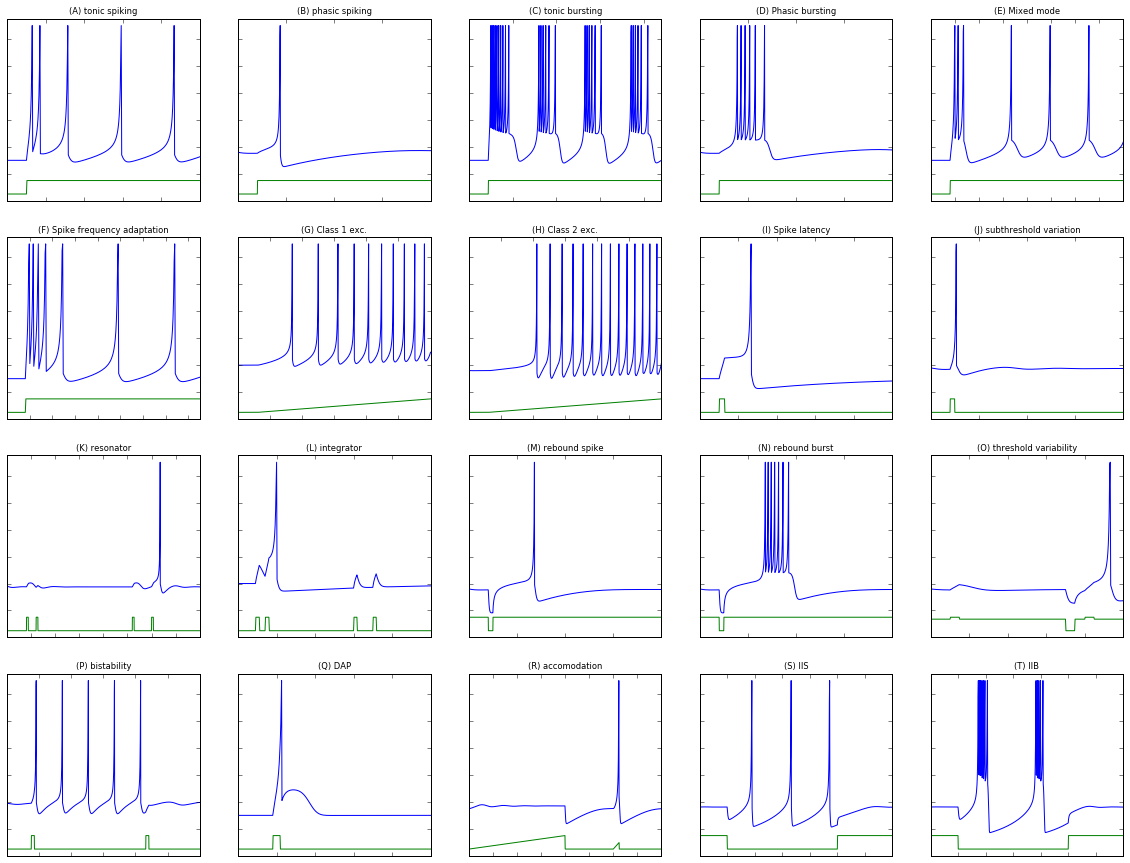

In [10]:
#   Programme orienté objet du modele de neurone Izhikevich 

import numpy as np
from math import *
from matplotlib.pyplot import *

class IzhNeurone:
  """Classe representant le modèle du neurone. L'intérêt de cette classe est l'initialisation 
  et de garder une trace des paramètres dans la simulation"""

  def __init__(self, label, a, b, c, d, v0, u0=None):
    """Definition des parametres du neurone selon l'équation du modele """

    self.label = label # Nom du neurone

#Parametres equations
    self.a = a
    self.b = b
    self.c = c
    self.d = d

#Condiotns initiales
    self.v = v0 
    self.u = u0 if u0 is not None else b*v0 


class IzhSimu:
  """ Cette classe va permettre d'effectuer toutes les différentes simulations du neurone
      Elle garde en trace le neurone durant la simulation, le temps total et le pas de temps, 
      le stimulus en entrée ainsi qu'une méthode d'intégration"""

  def __init__(self, n, T, dt=0.25):
    """ Définition de tous les paramètres globaux de la simulation """
    self.neuron = n
    self.dt     = dt
    self.t      = t = np.arange(0, T+dt, dt)
    self.stim   = np.zeros(len(t))
    self.x      = 5 #param constant dans l'equation
    self.y      = 140 #param constant dans l'eqaution
    self.du     = lambda a, b, v, u: a*(b*v - u)

  def integrate(self, n=None):
    """ Méthode d'intégration numérique du modèle et de son équation """

    if n is None: n = self.neuron
    trace = np.zeros((2,len(self.t))) # tableau a 2 dimensions
    for i, j in enumerate(self.stim): # Utilisation de la méthode d'Euler au premier ordre
      n.v += self.dt * (0.04*n.v**2 + self.x*n.v + self.y - n.u + self.stim[i])
      n.u += self.dt * self.du(n.a, n.b, n.v, n.u)
      if n.v > 30:
        trace[0,i] = 30 #Remise a 30 pour garder la même hauteur de pic
        n.v        = n.c
        n.u       += n.d
      else:
        trace[0,i] = n.v
        trace[1,i] = n.u
    return trace # On renvoie v et u 


#A present voici les diffentes classes de simulations a aprtir des donnees de Izhikevich : http://www.izhikevich.org/human_brain_simulation/Blue_Brain.htm

sims = []

## (A) tonic spiking
n = IzhNeurone("(A) tonic spiking", a=0.02, b=0.2, c=-65, d=6, v0=-70)
s = IzhSimu(n, T=100)
for i, t in enumerate(s.t):
  s.stim[i] = 14 if t > 10 else 0
sims.append(s)

##(B) Phasic spiking
n=IzhNeurone("(B) phasic spiking", a=0.02, b=0.25, c=-65, d=6, v0=-64)
s=IzhSimu(n,T=200)
for i, t in enumerate(s.t):
  s.stim[i] = 0.5 if t > 20 else 0
sims.append(s)

##(C) Tonic bursting
n=IzhNeurone("(C) tonic bursting", a=0.02, b=0.2, c=-50, d=2, v0=-70)
s=IzhSimu(n,T=220)
for i, t in enumerate(s.t):
  s.stim[i] = 15 if t > 22 else 0
sims.append(s)

##(D) Phasic bursting
n=IzhNeurone("(D) Phasic bursting", a=0.02, b=0.25, c=-55, d=0.05, v0=-64)
s=IzhSimu(n,T=200,dt=0.2)
for i, t in enumerate(s.t):
  s.stim[i] = 0.6 if t > 20 else 0
sims.append(s)

##(E) Mixed mode
n=IzhNeurone("(E) Mixed mode", a=0.02, b=0.2, c=-55, d=4, v0=-70)
s=IzhSimu(n,T=160)
for i, t in enumerate(s.t):
  s.stim[i] = 10 if t > 16 else 0
sims.append(s)

##(F) Spike frequency adaptation
n=IzhNeurone("(F) Spike frequency adaptation", a=0.01, b=0.2, c=-65, d=8, v0=-70)
s=IzhSimu(n,T=85)
for i, t in enumerate(s.t):
  s.stim[i] = 35 if t > 8 else 0
sims.append(s)

## (G) Class 1 exc.
n = IzhNeurone("(G) Class 1 exc.", a=0.02, b=-0.1, c=-55, d=6, v0=-60)
s = IzhSimu(n, T=300)
s.x = 4.1
s.y = 108
for i, t in enumerate(s.t):
  s.stim[i] = 0.075*(t-30) if t > 30 else 0
sims.append(s)

## (H) Class 2 exc.
n = IzhNeurone("(H) Class 2 exc.", a=0.2, b=0.26, c=-65, d=0, v0=-64)
s = IzhSimu(n, T=300)
for i, t in enumerate(s.t):
  s.stim[i] = -0.5+0.015*(t-30) if t > 30 else -0.5
sims.append(s)

## (I) Spike latency
n = IzhNeurone("(I) Spike latency", a=0.02, b=0.2, c=-65, d=6, v0=-70)
s = IzhSimu(n, T=100,dt=0.2)
for i, t in enumerate(s.t):
  s.stim[i] = 7.04 if (t > 10 and t<13)  else 0
sims.append(s)

## (J) subthreshold variation
n = IzhNeurone("(J) subthreshold variation", a=0.05, b=0.26, c=-60, d=0, v0=-62)
s = IzhSimu(n, T=200)
for i, t in enumerate(s.t):
  s.stim[i] = 2. if (t > 20 and t<25)  else 0
sims.append(s)

## (K) resonator
n = IzhNeurone("(K) resonator", a=0.1, b=0.26, c=-60, d=-1, v0=-62)
s = IzhSimu(n, T=400)
for i, t in enumerate(s.t):
  if t >40 and t<44 :     s.stim[i] = 0.65
  elif t>60 and t < 64:   s.stim[i] = 0.65
  elif t>260 and t < 264: s.stim[i] = 0.65
  elif t>300 and t<304: s.stim[i]=0.65
  else:           s.stim[i] = 0
sims.append(s)

## (L) integrator
n = IzhNeurone("(L) integrator", a=0.02, b=-0.1, c=-55, d=6, v0=-60)
s = IzhSimu(n, T=100)
s.x=4.1
s.y=108.
for i, t in enumerate(s.t):
  if t >(100./11.) and t<(100./11.)+2 :     s.stim[i] = 9.
  elif t>(100./11.)+5 and t < (100./11.)+7:   s.stim[i] = 9.
  elif t>60 and t < 62: s.stim[i] = 9.
  elif t>70 and t<72: s.stim[i]=9.
  else:           s.stim[i] = 0
sims.append(s)

## (M) rebound spike
n = IzhNeurone("(M) rebound spike", a=0.03, b=0.25, c=-60, d=4, v0=-64)
s = IzhSimu(n, T=200,dt=0.2)
for i, t in enumerate(s.t):
    s.stim[i] = -15 if (t>20 and t<25) else 0
  
sims.append(s)


## (N) rebound burst
n = IzhNeurone("(N) rebound burst", a=0.03, b=0.25, c=-52, d=0, v0=-64)
s = IzhSimu(n, T=200,dt=0.2)
for i, t in enumerate(s.t):
    s.stim[i] = -15 if (t>20 and t<25) else 0
  
sims.append(s)

## (O) threshold variability
n = IzhNeurone("(O) threshold variability", a=0.03, b=0.25, c=-60, d=4, v0=-64)
s = IzhSimu(n, T=100)
for i, t in enumerate(s.t):
  if 10 < t < 15:     s.stim[i] = 1.
  elif 80 < t < 85:   s.stim[i] = 1
  elif 70 < t < 75 : s.stim[i] = -6
  else:           s.stim[i] = 0
  
sims.append(s)

## (P) bistability
n = IzhNeurone("(P) bistability", a=0.1, b=0.26, c=-60, d=0, v0=-61)
s = IzhSimu(n, T=300)
for i, t in enumerate(s.t):
  if (300./8.) < t < (300./8. + 5):     s.stim[i] = 1.24
  elif 216 < t < 221:   s.stim[i] = 1.24
  else:           s.stim[i] = 0.24
  
sims.append(s)

## (Q) depolarizing after potential
n = IzhNeurone("(Q) DAP", a=1., b=0.2, c=-60, d=-21, v0=-70)
s = IzhSimu(n, T=50,dt=0.1)
for i, t in enumerate(s.t):
  if abs(t-10) < 1:     s.stim[i] = 20
  else:           s.stim[i] = 0
  
sims.append(s)

## (R) accomodation
n = IzhNeurone("(R) accomodation", a=0.02, b=1, c=-55, d=4, v0=-65, u0=-16)
s = IzhSimu(n, T=400, dt=0.5)
s.du = lambda a, b, v, u: a*(b*(v + 65))
for i, t in enumerate(s.t):
  if t < 200:     s.stim[i] = t/25
  elif t < 300:   s.stim[i] = 0
  elif t < 312.5: s.stim[i] = (t-300)/12.5*4
  else:           s.stim[i] = 0
sims.append(s)

## (S) inhibition-induced spiking
n = IzhNeurone("(S) IIS", a=-0.02, b=-1, c=-60, d=8, v0=-63.8)
s = IzhSimu(n, T=350,dt=0.5)
for i, t in enumerate(s.t):
  if t<50:     s.stim[i] = 80
  elif t> 250: s.stim[i]=80
  else:           s.stim[i] = 75
  
sims.append(s)

## (T) inhibition induced bursting
n = IzhNeurone("(T) IIB", a=-0.026, b=-1, c=-45, d=-2, v0=-63.8)
s = IzhSimu(n, T=350,dt=0.5)
for i, t in enumerate(s.t):
  if t<50:     s.stim[i] = 80
  elif t> 250: s.stim[i]=80
  else:           s.stim[i] = 75
  
sims.append(s)


#On trace tout a aprtir des donnes du modele
figure(figsize=(20,15))
for i,s in enumerate(sims):
  res = s.integrate()
  ax  = subplot(4,5,i+1)

  ax.plot(s.t, res[0], s.t, -95 + ((s.stim - min(s.stim))/(max(s.stim) - min(s.stim)))*10)

  ax.set_xlim([0,s.t[-1]])
  ax.set_ylim([-100, 35])
  ax.set_title(s.neuron.label, size="small")
  ax.set_xticklabels([])
  ax.set_yticklabels([])
show()